### Imports

In [1]:
import pandas as pd
import geopandas as gpd
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

### Load datasets

In [2]:
tfr_data = pd.read_csv('../data/children-per-woman-un.csv')
afb_data = pd.read_csv('../data/average-childbearing-age.csv').drop(columns='Code')

### Plot panel A

/tmp/ipykernel_3301/3163813110.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


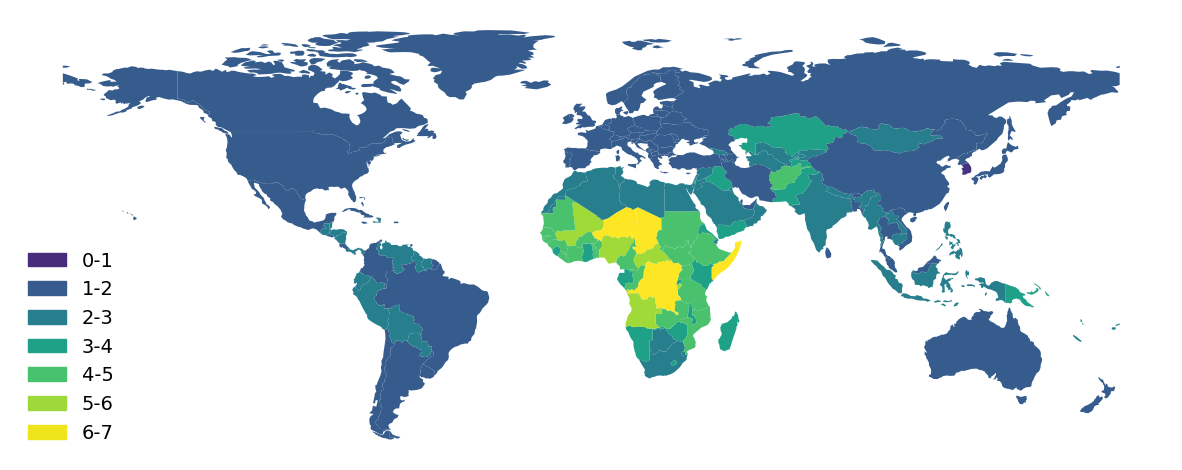

In [3]:
def plot_fertility_map(df, save=False):
    # Ensure the 'Entity' column is set as the index
    df.set_index('Entity', inplace=True)

    # Filter for the latest year available
    latest_year = df['Year'].max()
    latest_data = df[df['Year'] == latest_year]

    # Load the world map data
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Update names of specific countries
    name_mapping = {
        "United States of America": "United States",
        "Dem. Rep. Congo": "Democratic Republic of Congo",
        "Central African Rep.": "Central African Republic",
        "W. Sahara": "Western Sahara",
        "S. Sudan": "South Sudan",
        "Côte d'Ivoire": "Cote d'Ivoire",
        "eSwatini": "Eswatini"
    }
    world['name'] = world['name'].replace(name_mapping)

    # Merge the world map data with fertility data
    world = world.merge(latest_data, how='left', left_on='name', right_index=True)

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Remove spines and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Reverse viridis color scheme
    norm = Normalize(vmin=0, vmax=7)
    sm = ScalarMappable(norm=norm, cmap='viridis')

    # Plot the map with the reversed color scheme
    world.plot(column='Fertility rate - Sex: all - Age: all - Variant: estimates',
               ax=ax,
               scheme="User_Defined",
               legend=True,
               classification_kwds=dict(bins=[0,1,2,3,4,5,6,7]),
               cmap='viridis')
    
    # Calculate highest value for each bin
    bin_max_values = [latest_data[(latest_data['Fertility rate - Sex: all - Age: all - Variant: estimates'] >= i) & 
                                   (latest_data['Fertility rate - Sex: all - Age: all - Variant: estimates'] < i+1)]['Fertility rate - Sex: all - Age: all - Variant: estimates'].max() 
                      for i in range(7)]
    
    # Create custom legend labels
    legend_labels = [f'{i}-{i+1}' for i in range(7)]
    
    # Create custom legend handles with square markers colored by the highest value in each bin
    handles = [plt.Rectangle((0, 0), 1, 1, color=sm.to_rgba(bin_max_values[i]), label=label) for i, label in enumerate(legend_labels)]
    
    # Create custom legend
    ax.legend(handles=handles, loc='lower left', frameon=False, fontsize=14)

    if save == True:
        plt.savefig('../figures/nat-aging-fig1A.pdf', dpi=1200, bbox_inches='tight')
    else:
        plt.show()

# Example usage
# Assuming 'tfr_data' is your DataFrame containing fertility data
# Replace it with your actual DataFrame name
plot_fertility_map(tfr_data.copy(), save=False)

### Plot panel B

#### Preprocess

In [4]:
# Data to be added
data_to_add = [
    {'Entity': 'Italy', 'Year': 2020, 'Average childbearing age - UN (2019)': 31.4},
    {'Entity': 'United States', 'Year': 2020, 'Average childbearing age - UN (2019)': 30},
    {'Entity': 'India', 'Year': 2020, 'Average childbearing age - UN (2019)': 27.4},
    {'Entity': 'China', 'Year': 2020, 'Average childbearing age - UN (2019)': 27.6},
    {'Entity': 'South Korea', 'Year': 2020, 'Average childbearing age - UN (2019)': 32.3},
    {'Entity': 'Japan', 'Year': 2020, 'Average childbearing age - UN (2019)': 31.3},
    {'Entity': 'Russia', 'Year': 2020, 'Average childbearing age - UN (2019)': 28.8},
    {'Entity': 'United Kingdom', 'Year': 2020, 'Average childbearing age - UN (2019)': 30.7}
]

# Convert the data to a DataFrame
new_data = pd.DataFrame(data_to_add)

# Concatenate the existing DataFrame with the new DataFrame
afb_data = pd.concat([afb_data, new_data], ignore_index=True)

#### Plot

/tmp/ipykernel_3301/1668148504.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = pd.to_datetime(filtered_df['Year'], format='%Y')


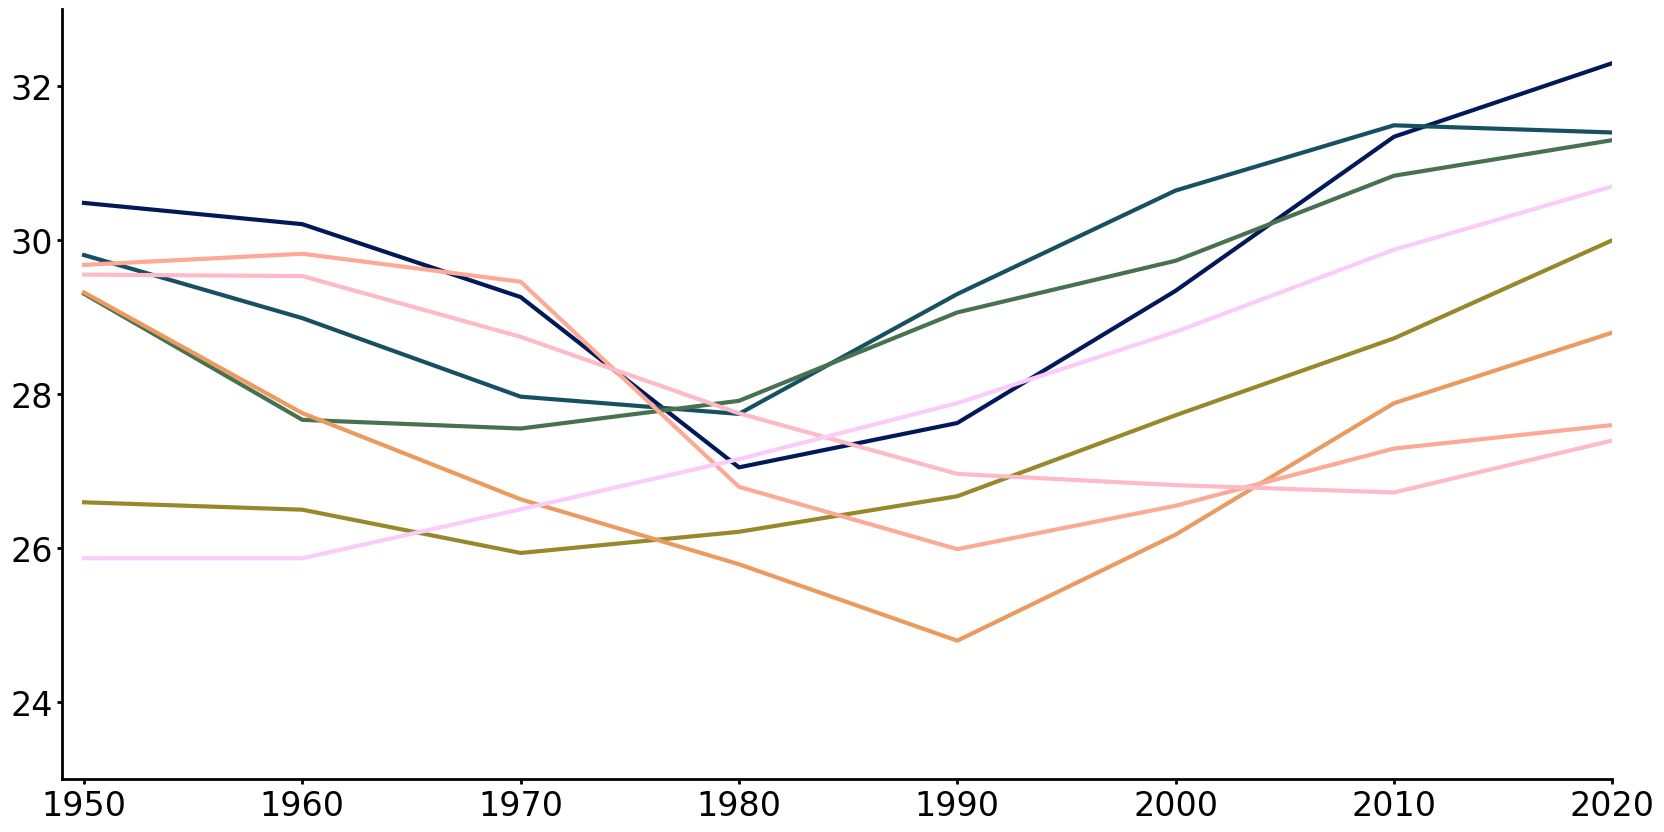

In [5]:
def plot_age_trend(df, save=False):
    # Filter the DataFrame for specified Entity values
    entity_values = ['South Korea', 'Italy', 'Japan', 'United States', 'Russia', 'China', 'India', 'United Kingdom']
    filtered_df = afb_data[afb_data['Entity'].isin(entity_values)]

    # Convert 'Year' column to datetime format
    filtered_df['Year'] = pd.to_datetime(filtered_df['Year'], format='%Y')

    # Filter data for every decade in the range 1950-2020
    filtered_df = filtered_df[(filtered_df['Year'].dt.year >= 1950) & (filtered_df['Year'].dt.year <= 2020) & (filtered_df['Year'].dt.year % 10 == 0)]

    # Define colors for the lines
    colors = ['#011959', '#165062', '#48714f', '#97882c', '#eb9a60', '#fca995', '#fdbac7', '#faccfa']

    # Plot line plot
    plt.figure(figsize=(20, 10))
    for i, entity in enumerate(entity_values):
        entity_data = filtered_df[filtered_df['Entity'] == entity]
        color = colors[i % len(colors)]  # Ensure colors wrap around if there are more entities than colors
        plt.plot(entity_data['Year'], entity_data['Average childbearing age - UN (2019)'], label=entity, linewidth=3, color=color)

    # Customizing the plot
    plt.ylim(23, 33)  # Set y-axis limit
    plt.grid(False)  # Turn off gridlines

    # Despine the right and top axes
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # Increase thickness of axes
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)

    # Increase font size for ticks
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.tick_params(axis='both', which='both', width=2)

    # Set x limit to (2015, 2020)
    plt.xlim(pd.Timestamp('1949'), pd.Timestamp('2020'))

    # Save the figure if save is True
    if save:
        plt.savefig('../figures/nat-aging-fig1B.pdf', dpi=1200, bbox_inches='tight')

    # Show plot
    plt.show()

# Example usage
plot_age_trend(afb_data, save=False)